Hi.

In this chapter i will create distibution of daily log_return for the EUR/USD exchange rate.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from pylab import mpl, plt
%matplotlib inline

plt.style.use('seaborn')


In [2]:
df = pd.read_csv('tr_eikon_eod_data.csv', index_col = 0, parse_dates = True).dropna()
df.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82
2010-01-08,30.282827,30.660,20.83,133.52,174.31,114.57,1144.98,18.13,1.4412,1136.10,49.84,111.37


Now i create log-return distribution for EUR/USD exchange rate.

In [3]:
column = 'EUR='

data = pd.DataFrame(df[column])

Here, i create a new column called, return which is the return values.

In [4]:
data['return'] = np.log(data/data.shift(1))

data.dropna(inplace = True)

Another column is created here that called direction that is sign of return multiply by 1(1 or -1).

In [5]:
data['direction'] = np.sign(data['return']).astype(int)

In [6]:
data.head()

,EUR=,return,direction
Date,,,
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1
2010-01-11,1.4513,0.006984,1


At this time i wanna create a histogram from return values to understand it deeply.

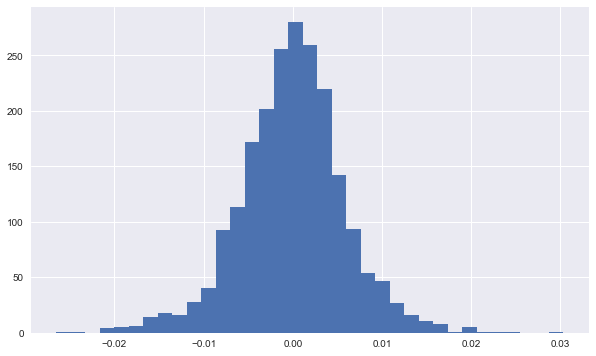

In [7]:
data['return'].hist(bins = 35,figsize =(10,6))

The code that creates the features data by lagging the log returns.

In [8]:
lags = 2


def create_lags(data):
    
    global cols
    cols=[]
    for lag in range(1, lags + 1):
        
        col = 'day_{}'.format(lag)
        data[col] = data['return'].shift(lag)
        cols.append(col)

In [9]:
create_lags(data)

In [10]:
data.head()

,EUR=,return,direction,day_1,day_2
Date,,,,,
2010-01-05,1.4368,-0.002988,-1,NaN,NaN
2010-01-06,1.4412,0.003058,1,-0.002988,NaN
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544


In [11]:
data.dropna(inplace = True)

### Regression for Time-Series

Sklearn is the most powerful tool for machine learning, and preprocessing also. Now i want to use Linear regression that a kind of supervised learning to predict values.

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
model = LinearRegression()

In [14]:
data['C1'] = model.fit(data[cols], data['return']).predict(data[cols])
data['C2'] = model.fit(data[cols], data['direction']).predict(data[cols])

Now we check what happened to our dataset especially in C1 and C2 columns.

In [15]:
data[['C1','C2']].head()

,C1,C2
Date,,
2010-01-07,-0.000166,-0.000086
2010-01-08,0.000017,0.040404
2010-01-11,-0.000244,-0.011756
2010-01-12,-0.000139,-0.043398
2010-01-13,-0.000022,0.002237


As we see C1 and C2, shows the predicted data now we want to seprate them to 2 different groups 1 and -1

In [16]:
data[['C1','C2']] = np.where(data[['C1','C2']] > 0,1,-1)

In [17]:
data.head()

,EUR=,return,direction,day_1,day_2,C1,C2
Date,,,,,,,
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988,-1,-1
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058,1,1
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544,-1,-1
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544,-1,-1
2010-01-13,1.4510,0.001103,1,-0.001310,0.006984,-1,1


Now, we can iterate in our dictionary and print C1 data.

In [18]:
one_neg =[]
one_pos =[]
for key,value in data.C2.items():
    if value ==1:
        one_pos.append(value)
    else:
        one_neg.append(value)
    
print('Number of +1 : ',len(one_pos))
print('Number of -1 : ',len(one_neg))

Number of +1 :  1377
Number of -1 :  758


In [19]:
data['pr1'] = data['C1']* data['return']
data['pr2'] = data['C2']* data['return']

data[['return','pr1','pr2']].sum().apply(np.exp)

return    0.810644
pr1       0.942422
pr2       1.339286
dtype: float64

In [20]:
(data['direction'] == data['C1']).value_counts()

False    1093
True     1042
dtype: int64

In [21]:
(data['direction']== data['C2']).value_counts()

True     1096
False    1039
dtype: int64

Upper lines shows the number of correct and incorrect predictions by current strategy.

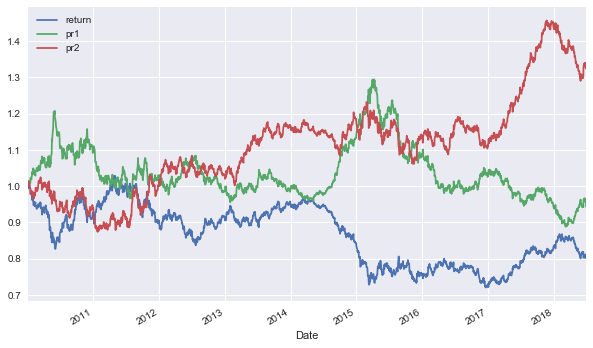

In [22]:
data[['return','pr1','pr2']].cumsum().apply(np.exp).plot(figsize =(10,6))

### Clustering

It is basically a type of unsupervised learning method . An unsupervised learning method is a method in which we draw references from datasets consisting of input data without labeled responses. Generally, it is used as a process to find meaningful structure, explanatory underlying processes, generative features, and groupings inherent in a set of examples.

Clustering is the task of dividing the population or data points into a number of groups such that data points in the same groups are more similar to other data points in the same group and dissimilar to the data points in other groups. It is basically a collection of objects on the basis of similarity and dissimilarity between them. 

In [23]:
from sklearn.cluster import KMeans

In [24]:
model = KMeans(n_clusters=2, random_state=0)

In [25]:
model.fit(data[cols])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [26]:
data['pos_clus'] = model.predict(data[cols])
data['pos_clus'] = np.where(data['pos_clus']==1,-1,1)

data['pos_clus'].values

array([-1,  1, -1, ...,  1,  1, -1])

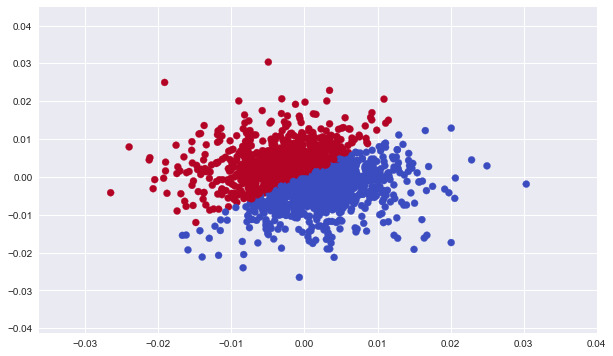

In [27]:
plt.figure(figsize=(10,6))
plt.scatter(data[cols].iloc[:,0], data[cols].iloc[:,1],
           c =data['pos_clus'], cmap = 'coolwarm')

In [28]:
data['pr'] = data['pos_clus'] * data['return']

data[['return','pr']].sum().apply(np.exp)

return    0.810644
pr        1.277133
dtype: float64

In [29]:
(data['direction'] == data['pos_clus']).value_counts()

True     1077
False    1058
dtype: int64

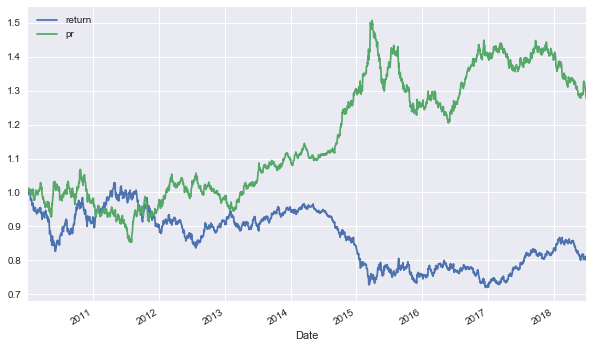

In [30]:
data[['return','pr']].cumsum().apply(np.exp).plot(figsize = (10,6))

## What Is Frequency Distribution?  

Frequency distribution is a representation, either in a graphical or tabular format, that displays the number of observations within a given interval. The interval size depends on the data being analyzed and the goals of the analyst. The intervals must be mutually exclusive and exhaustive. Frequency distributions are typically used within a statistical context. Generally, frequency distribution can be associated with the charting of a normal distribution.`

In [39]:
def bins(data, bins=[0]):
    
    global cols_bin
    cols_bin =[]
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins =bins)
        cols_bin.append(col_bin)
    

In [41]:
bins(data)
data[cols_bin +  ['direction']].head()

,day_1_bin,day_2_bin,direction
Date,,,
2010-01-07,1,0,-1
2010-01-08,0,1,1
2010-01-11,1,0,1
2010-01-12,1,1,-1
2010-01-13,0,1,1


In [42]:
grouped = data.groupby(cols_bin + ['direction'])
grouped.size()

day_1_bin  day_2_bin  direction
0          0          -1           239
                       0             4
                       1           258
           1          -1           262
                       1           288
1          0          -1           272
                       0             1
                       1           278
           1          -1           278
                       0             4
                       1           251
dtype: int64

In [44]:
res = grouped['direction'].size().unstack(fill_value = 0)

In [46]:
def highligth_max(s):
    is_max = s ==s.max()
    
    return ['background-color : yellow' if v else '' for v in is_max]

In [47]:
res.style.apply(highligth_max, axis=1)

In [48]:
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1)==2,-1,1)

(data['direction'] == data['pos_freq']).value_counts()

True     1102
False    1033
dtype: int64

In [49]:
data['strat_freq'] = data['pos_freq'] * data['return']

In [50]:
data[['return','strat_freq']].sum().apply(np.exp)

return        0.810644
strat_freq    0.989513
dtype: float64

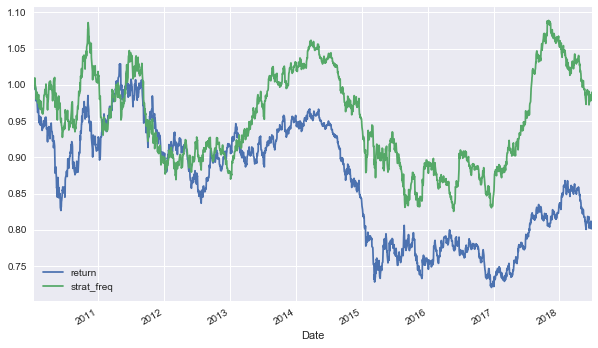

In [51]:
data[['return','strat_freq']].cumsum().apply(np.exp).plot(figsize =(10,6) )

## Classification

In machine learning and statistics, classification is the problem of identifying to which of a set of categories (sub-populations) a new observation belongs, on the basis of a training set of data containing observations (or instances) whose category membership is known. Examples are assigning a given email to the "spam" or "non-spam" class, and assigning a diagnosis to a given patient based on observed characteristics of the patient (sex, blood pressure, presence or absence of certain symptoms, etc.). Classification is an example of pattern recognition.

In the terminology of machine learning, classification is considered an instance of supervised learning, i.e., learning where a training set of correctly identified observations is available. The corresponding unsupervised procedure is known as clustering, and involves grouping data into categories based on some measure of inherent similarity or distance. 

### Using Binary features

In [52]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [53]:
C=1

models ={
    'log-reg':linear_model.LogisticRegression(C=C),
    'gauss_nb':GaussianNB(),
    'svm':SVC(C=C)
}

In [54]:
def fit_models(data):
    mfit ={model:models[model].fit(data[cols_bin], data['direction'])
          for model in models.keys()}
    
    

In [55]:
fit_models(data)

/Users/rop/data/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rop/data/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/rop/data/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [56]:
def derive_position(data):
    
    for model in models.keys():
        
        data['pos_' + model]  = models[model].predict(data[cols_bin])

In [57]:
derive_position(data)

In [58]:
def evaluate(data):
    
    global sel
    sel = []
    for model in models.keys():
        col = 'strat_' + model
        data[col] = data['pos_' + model] * data['return']
        sel.append(col)
    

In [59]:
evaluate(data)

In [60]:
sel.insert(1, 'strat_freq')

In [61]:
data[sel].sum().apply(np.exp)

strat_log-reg     1.243322
strat_freq        0.989513
strat_gauss_nb    1.243322
strat_svm         0.989513
dtype: float64

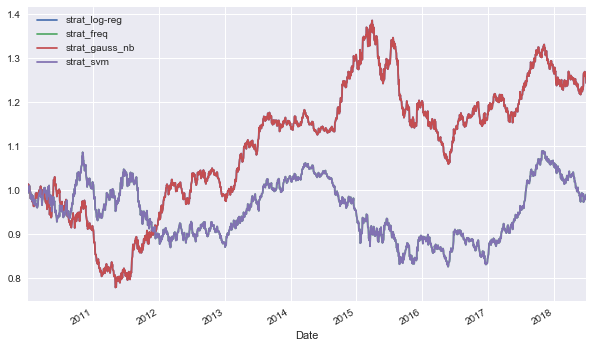

In [62]:
data[sel].cumsum().apply(np.exp).plot(figsize =(10,6))